In [148]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_fig
from ad_ied.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator
from statannotations.Annotator import Annotator
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'D:\github\ad_ied\results'


## load replay results

In [163]:
save_path = r"D:\github\ad_ied\results\replay_v3"

df = replay_run.load_results(save_path,pre_task_post=True,verbose=False)
# df = df.query("decoding_median_error < 23 & score_pval_col_cycle < 0.05 & score_pval_time_swap<0.05")


In [164]:
young = [
    r"X:\AD_sessions\AZ10\AZ10_210317_sess2",
    r"X:\AD_sessions\AZ10\AZ10_210322_sess4",
    r"X:\AD_sessions\AZ10\AZ10_210324_sess5",
    r"X:\AD_sessions\AZ10\AZ10_210329_sess6",
    r"X:\AD_sessions\AZ10\AZ10_210412_sess9",
    r"X:\AD_sessions\AZ10\AZ10_210419_sess11",
    r"X:\AD_sessions\AZ11\AZ11_210325_sess1",
    r"X:\AD_sessions\AZ11\AZ11_210422_sess7",
    r"X:\AD_sessions\AZ12\AZ12_210317_sess2",
    r"X:\AD_sessions\AZ12\AZ12_210323_sess3",
    r"X:\AD_sessions\AZ12\AZ12_210325_sess4",
    r"X:\AD_sessions\AZ12\AZ12_210330_sess5",
    r"X:\AD_sessions\AZ12\AZ12_210413_sess7",
    r"X:\AD_sessions\AZ18\AZ18_221119_sess4",
    r"X:\AD_sessions\AZ18\AZ18_221120_sess5",
    r"X:\AD_sessions\AZ18\AZ18_221121_sess6",
    r"X:\AD_sessions\AZ18\AZ18_221124_sess8",
    r"X:\AD_sessions\AZ18\AZ18_221129_sess10",
]
old = [
    r"X:\AD_sessions\AZ13\AZ13_220930_sess7",
    r"X:\AD_sessions\AZ13\AZ13_221003_sess8",
    r"X:\AD_sessions\AZ13\AZ13_221007_sess12",
    r"X:\AD_sessions\AZ16\AZ16_221101_sess4",
    r"X:\AD_sessions\AZ16\AZ16_221104_sess7",
    r"X:\AD_sessions\AZ16\AZ16_221109_sess10",
]
df["age_label"] = df.basepath.apply(lambda x: "old" if x in old else "young" if x in young else None)
df["age_label"].value_counts()

young    20230
old       1214
Name: age_label, dtype: int64

## get pre and post ied labels

In [166]:
def get_mutually_exclusive_epochs(
    ied_epochs, pre_interval=[-20, -10], post_interval=[0, 10]
):
    ied_obs_pre_ = nel.EpochArray(
        np.array(
            [ied_epochs.start + pre_interval[0], ied_epochs.start + pre_interval[1]]
        ).T
    )
    ied_obs_post_ = nel.EpochArray(
        np.array(
            [ied_epochs.stop + post_interval[0], ied_epochs.stop + post_interval[1]]
        ).T
    )

    ied_obs_pre = ied_obs_pre_[~ied_obs_post_]
    ied_obs_post = ied_obs_post_[~ied_obs_pre_]

    return ied_obs_pre, ied_obs_post


def extract_pre_post_ied_replay(basepath, df):
    current_df = df.query("basepath==@basepath")

    ied_epochs = loading.load_ied_events(basepath)
    if len(ied_epochs) == 0:
        print(f"no IED file {basepath}")
        return pd.DataFrame()

    ied_obs_pre, ied_obs_post = get_mutually_exclusive_epochs(ied_epochs)
    current_df["label"] = "other"
    idx = functions.in_intervals(current_df.start.values, ied_obs_pre.data)
    current_df.loc[idx, "label"] = "pre"
    idx = functions.in_intervals(current_df.start.values, ied_obs_post.data)
    current_df.loc[idx, "label"] = "post"

    return current_df


results_df = pd.DataFrame()
for basepath in df.basepath.unique():
    current_df = extract_pre_post_ied_replay(basepath, df)
    results_df = pd.concat([results_df, current_df],ignore_index=True)


no IED file X:\AD_sessions\Naz1\Naz1_210811_sess26


In [116]:
query = "epoch.str.contains('tmaze|post') & decoding_median_error < 25"
print(results_df.query(query).label.value_counts())

query = "epoch.str.contains('tmaze|post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"
print(results_df.query(query).label.value_counts())

other    18045
pre       2167
post      1639
Name: label, dtype: int64
other    2237
pre       276
post      188
Name: label, dtype: int64


## proportions of pre and post IED replays

In [155]:
prop_df = (
    results_df.query("epoch.str.contains('post') & decoding_median_error < 25")
    .groupby("basepath")
    .apply(
        lambda x: pd.Series(
            {
                "n_replays": len(x.query("score_pval_col_cycle < 0.05")),
                "n_canidates": len(x),
                "n_replays_pre_ied": len(x.query("score_pval_col_cycle < 0.05 & label=='pre'")),
                "n_canidates_pre_ied": len(x.query("label=='pre'")),
                "n_replays_post_ied": len(x.query("score_pval_col_cycle < 0.05 & label=='post'")),
                "n_canidates_post_ied": len(x.query("label=='post'"))
            }
        )
    )
    .reset_index()
)
# prop_df["prop_replay"] = prop_df.n_replays / prop_df.n_canidates
display(prop_df)
print(f"Overall proportion of replays compared to canidates: {prop_df.n_replays.sum() / prop_df.n_canidates.sum():.2f}")
print(f"Pre IED proportion of replays compared to canidates: {prop_df.n_replays_pre_ied.sum() / prop_df.n_canidates_pre_ied.sum():.2f}")
print(f"Post IED proportion of replays compared to canidates: {prop_df.n_replays_post_ied.sum() / prop_df.n_canidates_post_ied.sum():.2f}")
print(f"Post IED proportion of replays compared Pre IED replays: {prop_df.n_replays_post_ied.sum() / prop_df.n_replays_pre_ied.sum():.2f}")

stat, pval = proportions_ztest(
    prop_df[["n_replays_pre_ied","n_replays_post_ied"]].sum(),
    prop_df[["n_canidates_pre_ied","n_canidates_post_ied"]].sum()
)
print(f"pre post ied prop test p-value = {pval:.3f}")

,basepath,n_replays,n_canidates,n_replays_pre_ied,n_canidates_pre_ied,n_replays_post_ied,n_canidates_post_ied
0,X:\AD_sessions\AZ11\AZ11_210422_sess7,5,53,0,3,0,1
1,X:\AD_sessions\AZ11\AZ11_210427_sess8,419,5372,9,102,8,81
2,X:\AD_sessions\AZ12\AZ12_210317_sess2,21,90,2,18,2,6
3,X:\AD_sessions\AZ12\AZ12_210323_sess3,1358,8474,178,1145,110,761
4,X:\AD_sessions\AZ12\AZ12_210325_sess4,424,4375,76,785,54,688
5,X:\AD_sessions\AZ12\AZ12_210330_sess5,13,154,2,22,0,12
6,X:\AD_sessions\AZ13\AZ13_220930_sess7,21,153,1,12,4,10
7,X:\AD_sessions\AZ13\AZ13_221003_sess8,28,130,2,16,2,4
8,X:\AD_sessions\AZ13\AZ13_221007_sess12,24,162,0,0,0,4
9,X:\AD_sessions\AZ18\AZ18_221119_sess4,7,62,0,0,0,0


Overall proportion of replays compared to canidates: 0.12
Pre IED proportion of replays compared to canidates: 0.13
Post IED proportion of replays compared to canidates: 0.11
Post IED proportion of replays compared Pre IED replays: 0.68
pre post ied prop test p-value = 0.250


In [114]:
results_df.query("age_label=='old' & decoding_median_error < 25").basepath.unique()

array(['X:\\AD_sessions\\AZ13\\AZ13_220930_sess7',
       'X:\\AD_sessions\\AZ13\\AZ13_221003_sess8',
       'X:\\AD_sessions\\AZ13\\AZ13_221007_sess12'], dtype=object)

### plotting helper

In [97]:
def annotate_this(df,x,y,ax=None,hue=None):
    if ax is None:
        ax = plt.gca()
    box_pairs = [
        ("pre", "post"),
        ("other", "pre"),
        ("other", "post")
    ]
    annotator = Annotator(
        ax,
        box_pairs,
        data=df,
        x=x,
        y=y,
    )
    annotator.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="outside",
        comparisons_correction=None,
        verbose=0,
    )
    annotator.apply_and_annotate()

In [179]:
results_df.epoch.unique()

array(['pre_sleep', 'post_sleep', 'tmaze'], dtype=object)

In [184]:
for basepath in results_df.basepath.unique():
    pre_sleep_mean = results_df.query("basepath == @basepath & epoch=='pre_sleep'").trajectory_score.mean()
    results_df.loc[results_df.basepath == basepath,"traj_score_presleep_norm"] = results_df.query("basepath == @basepath").trajectory_score / pre_sleep_mean


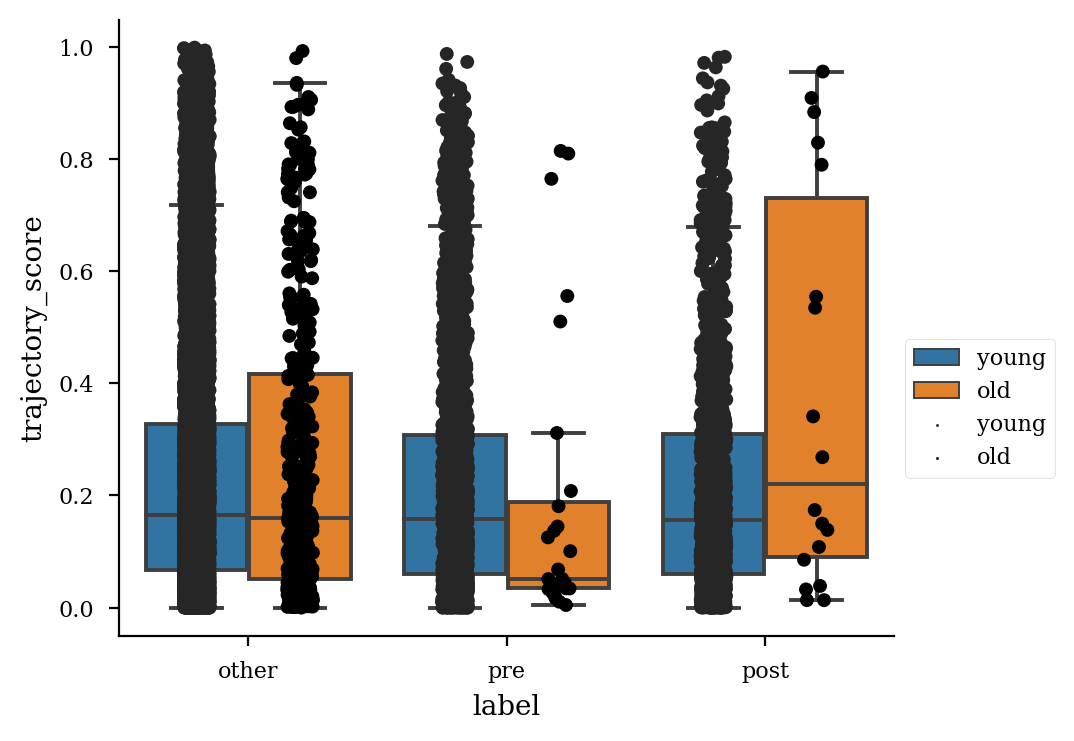

In [161]:
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5,4))
sns.boxplot(data=results_df.query(query),x="label",y="trajectory_score",hue="age_label",showfliers=False)
sns.stripplot(data=results_df.query(query),x="label",y="trajectory_score",hue="age_label",color="k",dodge=True)
# annotate_this(results_df.query(query),"label","trajectory_score",ax=plt.gca(),hue="age_label")
plt.gca().legend(bbox_to_anchor=(1, 0.5), markerscale=.1)
sns.despine()

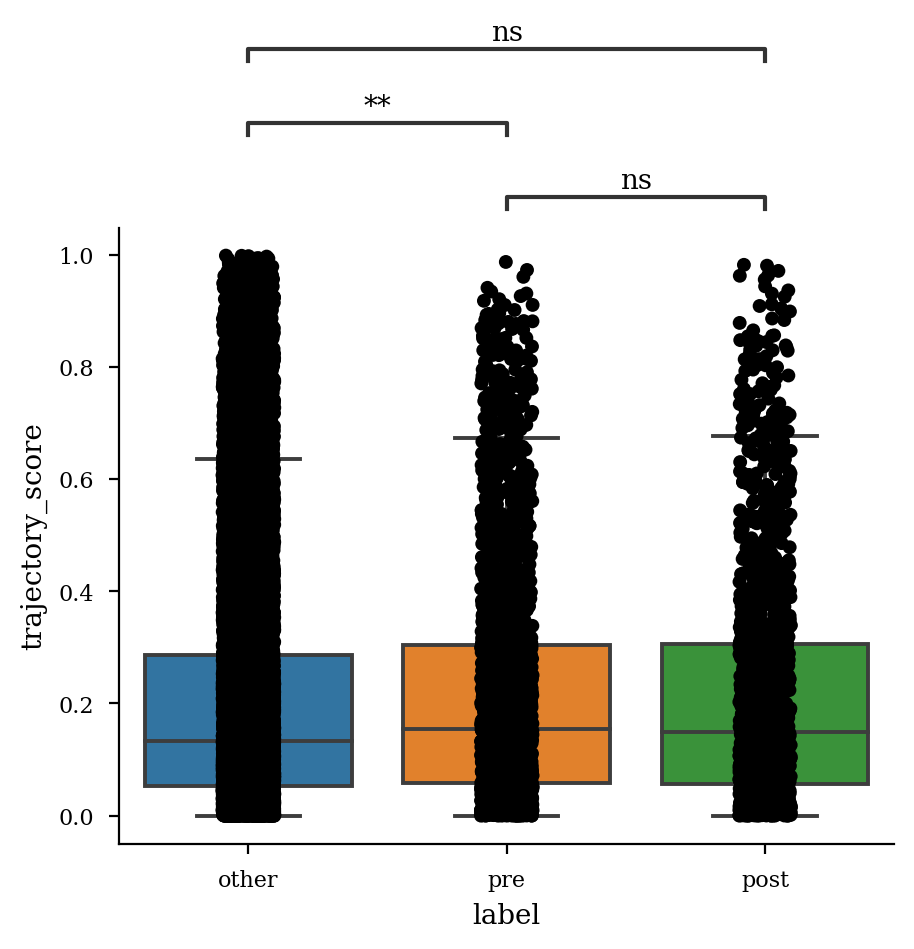

In [194]:
# query = "epoch.str.contains('tmaze|post') & decoding_median_error < 23 & score_pval_col_cycle < 0.05 & score_pval_time_swap<0.05"
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5,4))
sns.boxplot(data=results_df.query(query),x="label",y="trajectory_score",showfliers=False)
sns.stripplot(data=results_df.query(query),x="label",y="trajectory_score",color="k")
# plt.yscale("log")
annotate_this(results_df.query(query),"label","trajectory_score",plt.gca())
sns.despine()

# plt.savefig(r"D:\github\ad_ied\results\relay_trajectory_score.pdf",dpi=300,bbox_inches="tight")

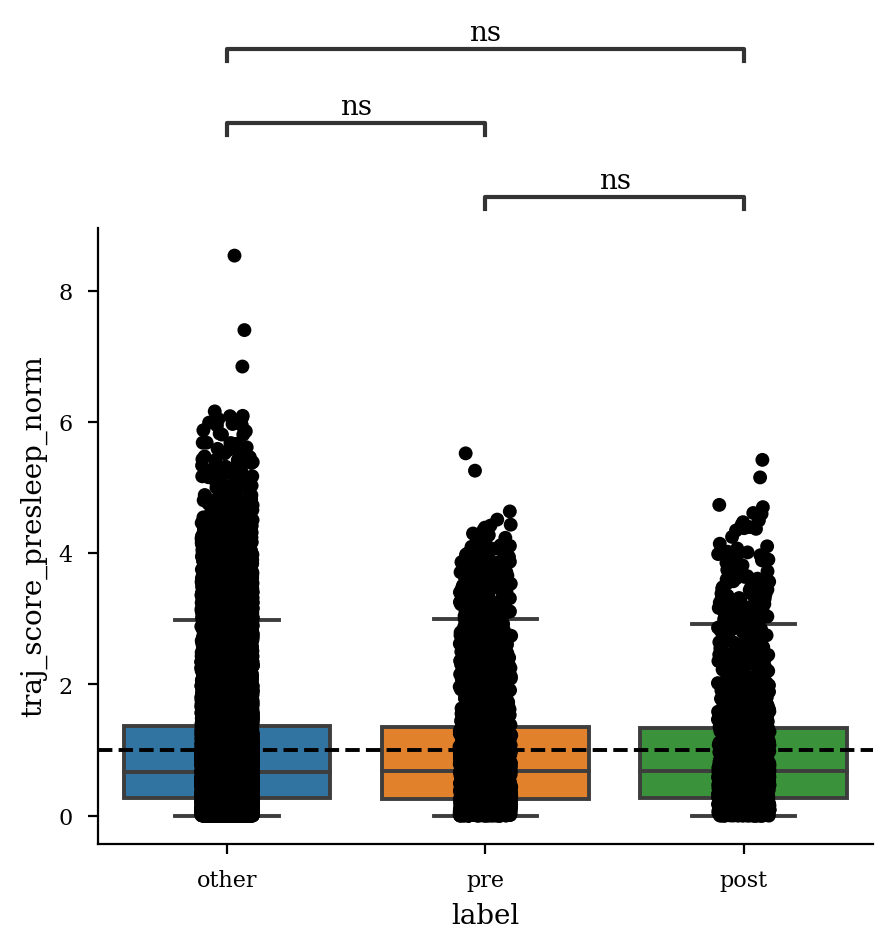

In [195]:
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5,4))
sns.boxplot(data=results_df.query(query),x="label",y="traj_score_presleep_norm",showfliers=False)
sns.stripplot(data=results_df.query(query),x="label",y="traj_score_presleep_norm",color="k")
# plt.yscale("log")
annotate_this(results_df.query(query),"label","traj_score_presleep_norm",plt.gca())
plt.axhline(1,color="k",linestyle="--")
sns.despine()


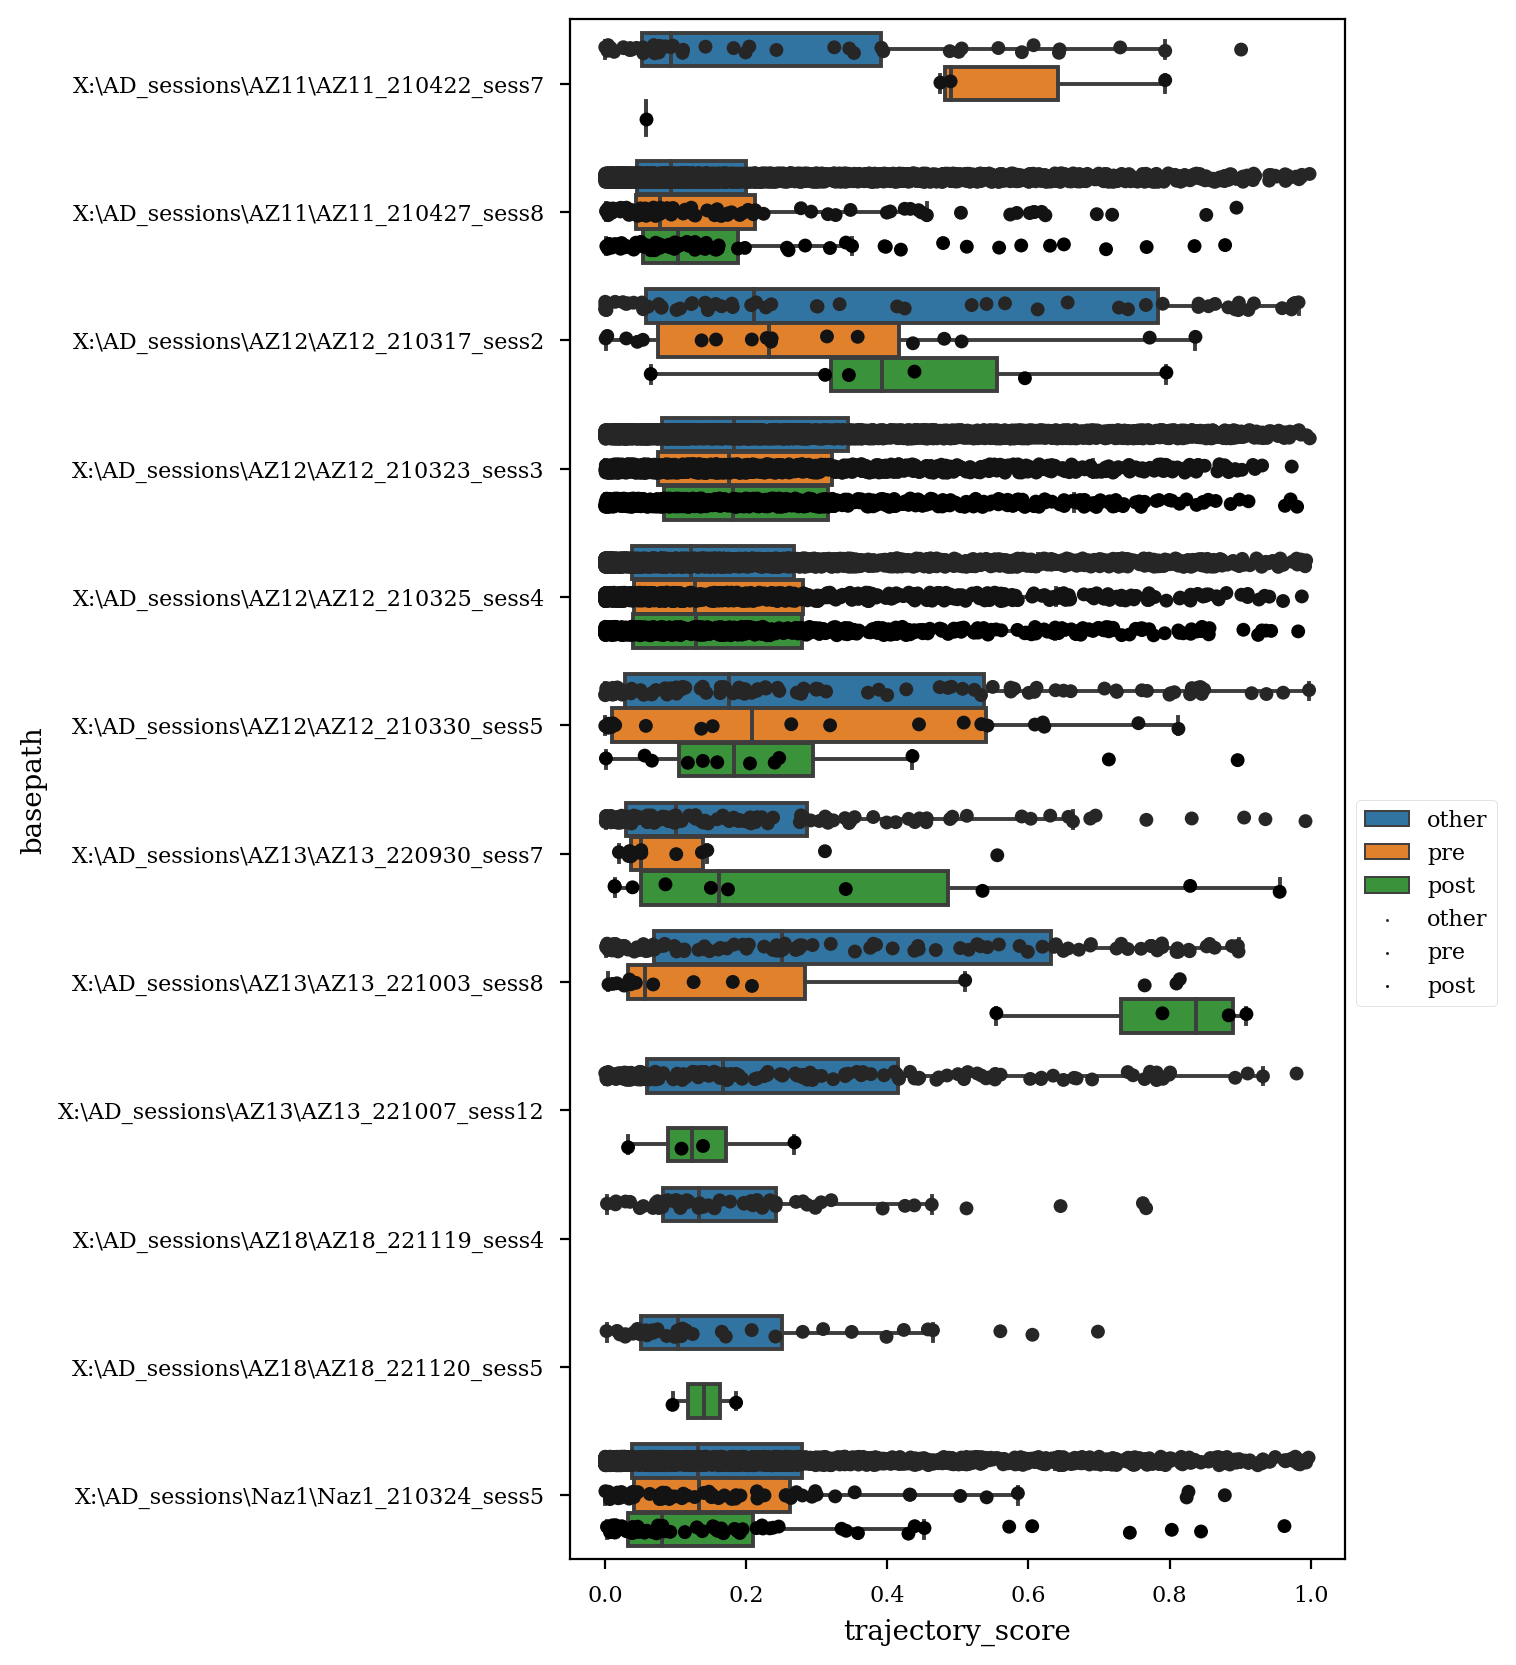

In [178]:
plt.figure(figsize=(5,10))
sns.boxplot(data=results_df.query(query),x="trajectory_score",y="basepath",hue="label",showfliers=False)
sns.stripplot(data=results_df.query(query),x="trajectory_score",y="basepath",hue="label",color="k",dodge=True)
plt.gca().legend(bbox_to_anchor=(1, 0.5), markerscale=.1)


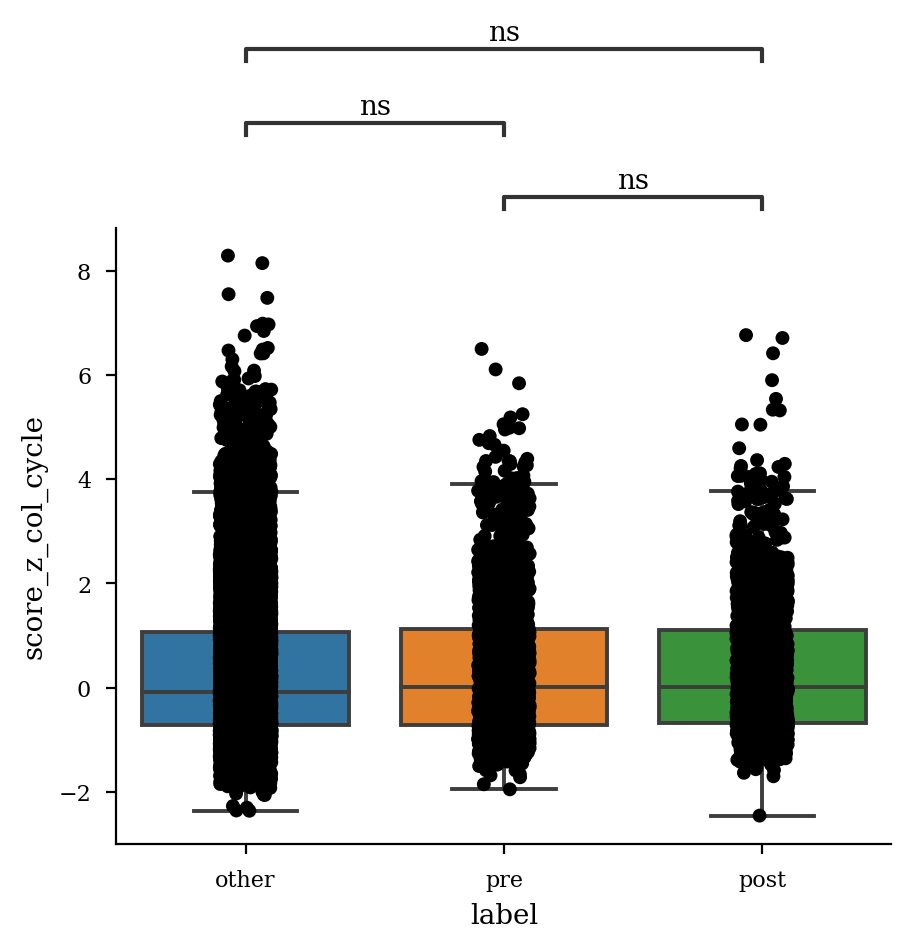

In [196]:
plt.figure(figsize=(5,4))
sns.boxplot(data=results_df.query(query),x="label",y="score_z_col_cycle",showfliers=False)
sns.stripplot(data=results_df.query(query),x="label",y="score_z_col_cycle",color="k")
annotate_this(results_df.query(query),"label","score_z_col_cycle",plt.gca())
sns.despine()

In [ ]:
results_df

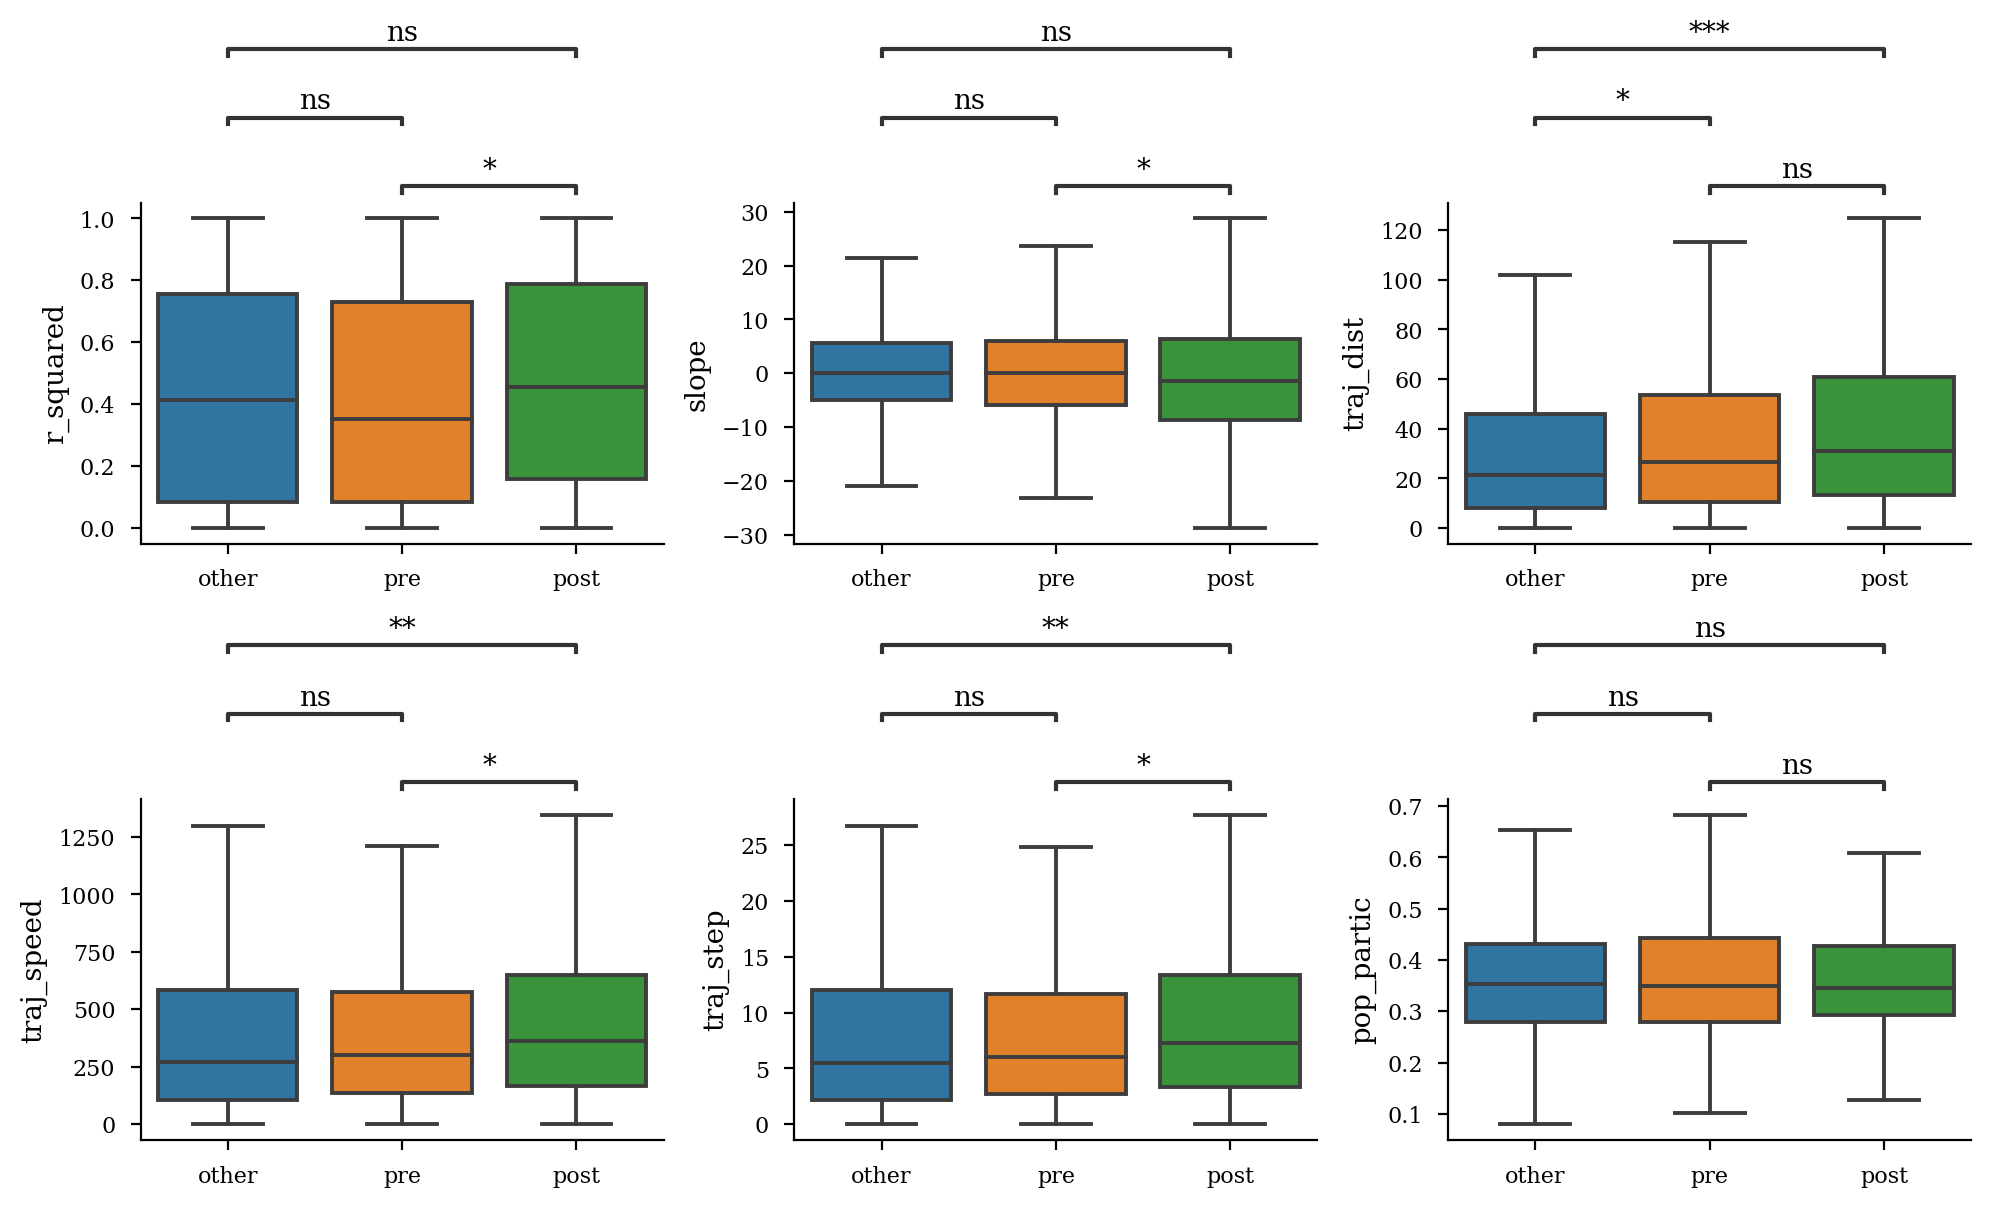

In [198]:
query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"

fig, ax = plt.subplots(2,3,
    figsize=functions.set_size("thesis", fraction=2, subplots=(2.5, 3)),
    edgecolor=None,
)
fig.subplots_adjust(hspace=0.75, wspace=0.25)
ax = ax.ravel()

sns.boxplot(data=results_df.query(query),x="label",y="r_squared",ax=ax[0],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="r_squared",color="k",ax=ax[0])
annotate_this(results_df.query(query),"label","r_squared",ax[0])

sns.boxplot(data=results_df.query(query),x="label",y="slope",ax=ax[1],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="slope",color="k",ax=ax[1])
annotate_this(results_df.query(query),"label","r_squared",ax[1])

sns.boxplot(data=results_df.query(query),x="label",y="traj_dist",ax=ax[2],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_dist",color="k",ax=ax[2])
annotate_this(results_df.query(query),"label","traj_dist",ax[2])

sns.boxplot(data=results_df.query(query),x="label",y="traj_speed",ax=ax[3],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_speed",color="k",ax=ax[3])
annotate_this(results_df.query(query),"label","traj_speed",ax[3])

sns.boxplot(data=results_df.query(query),x="label",y="traj_step",ax=ax[4],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_step",color="k",ax=ax[4])
annotate_this(results_df.query(query),"label","traj_speed",ax[4])

sns.boxplot(data=results_df.query(query),x="label",y="pop_partic",ax=ax[5],showfliers=False)
# sns.stripplot(data=results_df.query(query),x="label",y="pop_partic",color="k",ax=ax[5])
annotate_this(results_df.query(query),"label","pop_partic",ax[5])

for ax_ in ax:
    ax_.set_xlabel("")
sns.despine()

# plt.savefig(r"D:\github\ad_ied\results\other_replay_metrics.pdf",dpi=300,
#     bbox_inches="tight",
# )
plt.show()

In [128]:
def extract_replay_ied_psth(basepath, df):
    current_df = df.query("basepath==@basepath")

    ied_epochs = loading.load_ied_events(basepath)
    if len(ied_epochs) == 0:
        return pd.DataFrame(), pd.DataFrame()
    query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"
    psth_replay = functions.compute_psth([current_df.query(query).start.values],ied_epochs.start.values,bin_width=0.6, n_bins=100)
    query = "epoch.str.contains('post') & decoding_median_error < 25"
    psth_replay_canidate = functions.compute_psth([current_df.query(query).start.values],ied_epochs.start.values,bin_width=0.6, n_bins=100)

    return psth_replay, psth_replay_canidate

psth_replay = pd.DataFrame()
psth_replay_canidate = pd.DataFrame()

for basepath in df.basepath.unique():
    psth_replay_,psth_replay_canidate_ = extract_replay_ied_psth(basepath, df)

    psth_replay = pd.concat([psth_replay,psth_replay_],axis=1,ignore_index=True)
    psth_replay_canidate = pd.concat([psth_replay_canidate,psth_replay_canidate_],axis=1,ignore_index=True)


In [129]:
psth_replay_zscore = psth_replay.copy()
psth_replay_zscore[:] = (psth_replay.values - np.nanmean(psth_replay.values,axis=0)) / np.std(psth_replay.values,axis=0)

psth_replay_canidate_zscore= psth_replay_canidate.copy()
psth_replay_canidate_zscore[:] = (psth_replay_canidate.values - np.nanmean(psth_replay_canidate.values,axis=0)) / np.std(psth_replay_canidate.values,axis=0)

<AxesSubplot: >

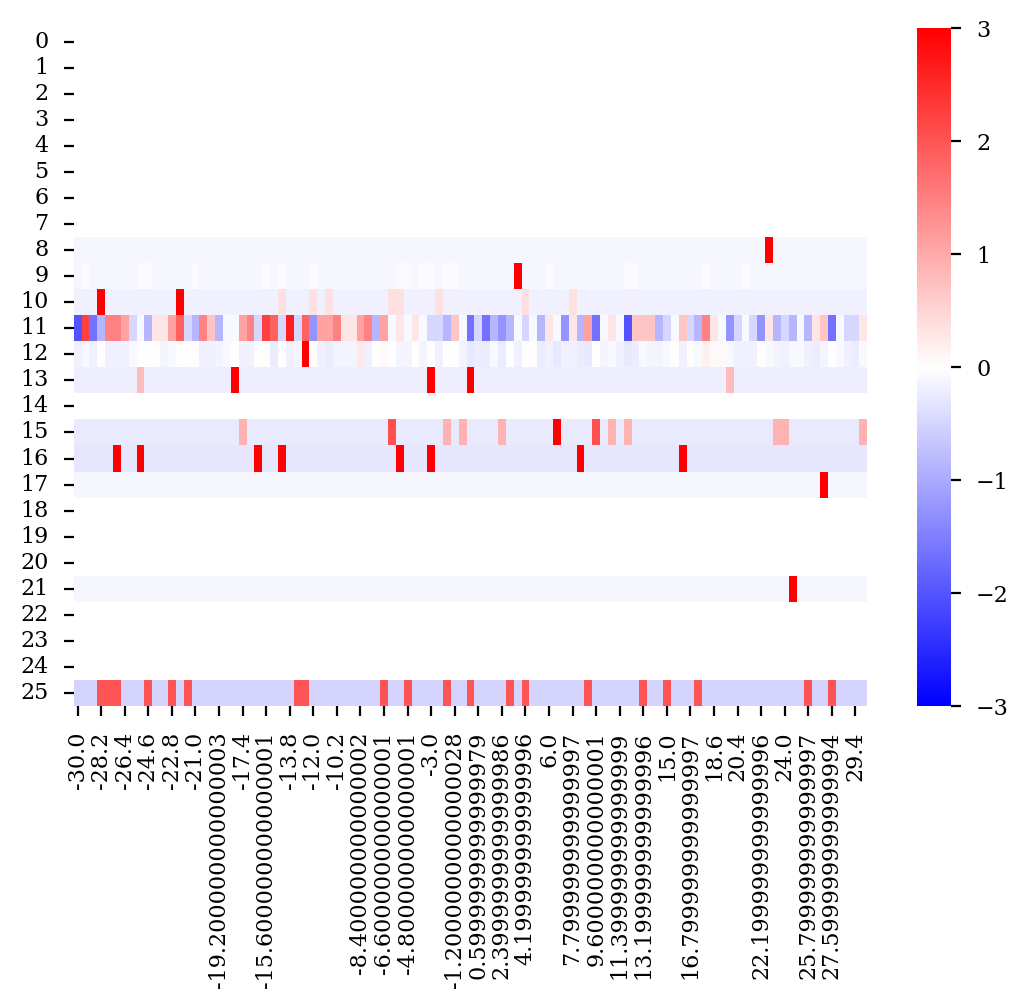

In [170]:
sns.heatmap(psth_replay_zscore.T,vmin=-3,vmax=3,cmap="bwr")

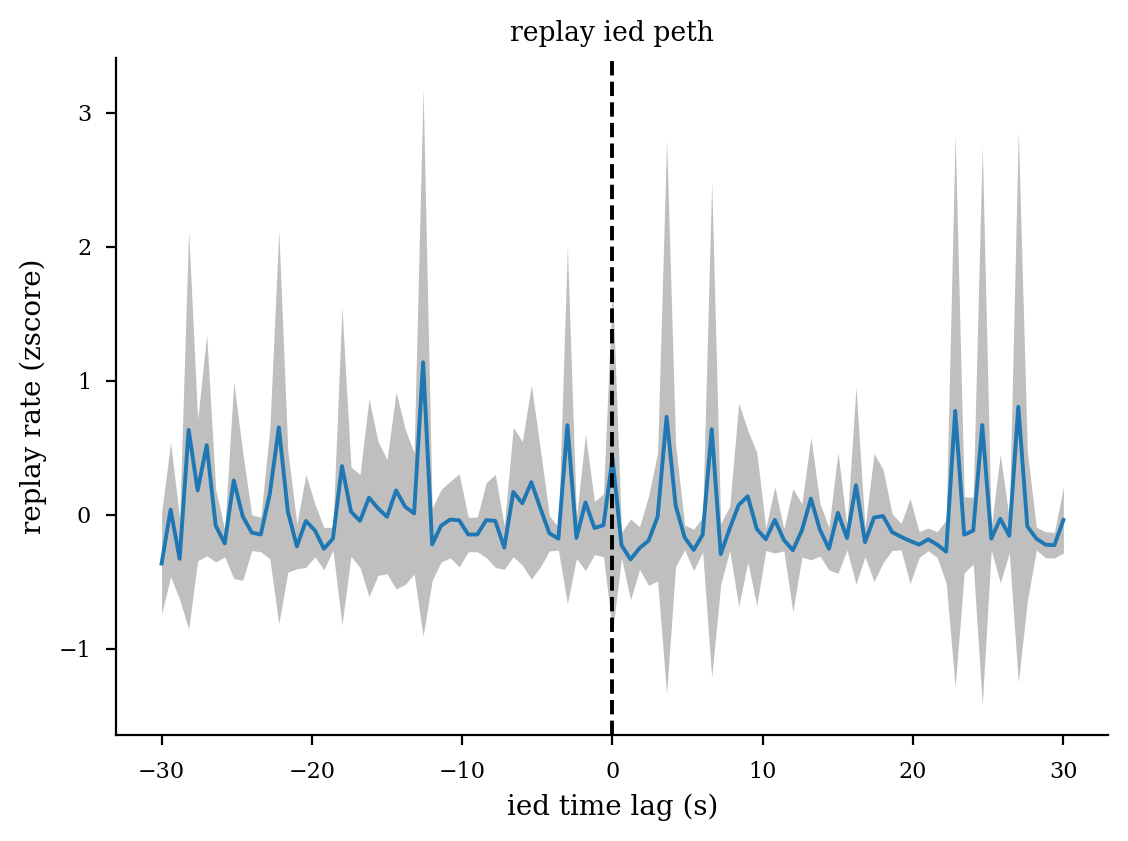

In [153]:
def confidence_intervals(X, conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X), axis=1) == 0, :]
    # compute interval for each column
    interval = [
        stats.t.interval(conf, len(a) - 1, loc=np.mean(a), scale=stats.sem(a))
        for a in X.T
    ]
    interval = np.vstack(interval)
    lower = interval[:, 0]
    upper = interval[:, 1]
    return lower, upper

lower, upper = confidence_intervals(psth_replay_zscore.values.T)
psth_replay_zscore.mean(axis=1).plot()

plt.fill_between(
    psth_replay_zscore.index,
    lower,
    upper,
    color="gray",
    alpha=0.5,
    linewidth=0,
)

plt.xlabel("ied time lag (s)")
plt.ylabel("replay rate (zscore)")
plt.title("replay ied peth")
plt.axvline(0,color="k",linestyle="--")
sns.despine()
# plt.savefig(r"D:\github\ad_ied\results\avg_replay_ied_peth.pdf",dpi=300,
#     bbox_inches="tight",
# )

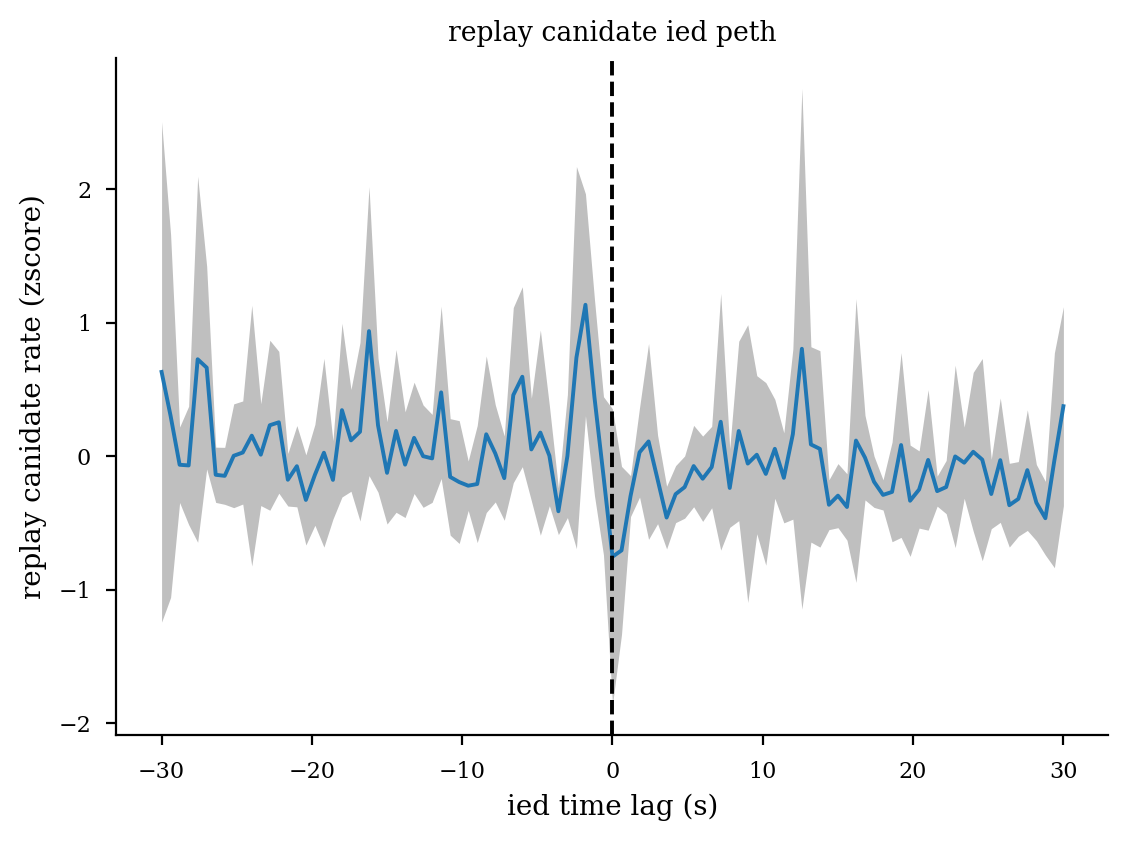

In [152]:
lower, upper = confidence_intervals(psth_replay_canidate_zscore.values.T)
psth_replay_canidate_zscore.mean(axis=1).plot()

plt.fill_between(
    psth_replay_canidate_zscore.index,
    lower,
    upper,
    color="gray",
    alpha=0.5,
    linewidth=0,
)

plt.xlabel("ied time lag (s)")
plt.ylabel("replay canidate rate (zscore)")
plt.title("replay canidate ied peth")
plt.axvline(0,color="k",linestyle="--")
sns.despine()

### testing below

In [3]:
# basepath = r"X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5"
basepath = r"X:\AD_sessions\AZ12_210323_sess3"
ied_epochs = loading.load_ied_events(basepath)
ied_epochs

,start,stop,center
0,2408.8032,2408.8752,2408.8392
1,2439.7336,2439.7888,2439.7592
2,2440.1552,2440.2568,2440.2024
3,2443.2608,2443.3240,2443.2880
4,2445.1768,2445.2488,2445.2144
...,...,...,...
151,22235.8976,22235.9520,22235.9216
152,22267.4152,22267.4720,22267.4408
153,22317.4920,22317.5480,22317.5176
154,22321.9656,22322.0248,22321.9920


In [11]:
current_df.epoch.str.contains("post")

15783    False
15808    False
15820    False
15828    False
15829    False
         ...  
27559     True
27569     True
27587     True
27589     True
27591     True
Name: epoch, Length: 1799, dtype: bool

In [12]:
current_df = df.query("basepath == @basepath & epoch.str.contains('post')")

In [31]:
current_df.shape

(1799, 23)

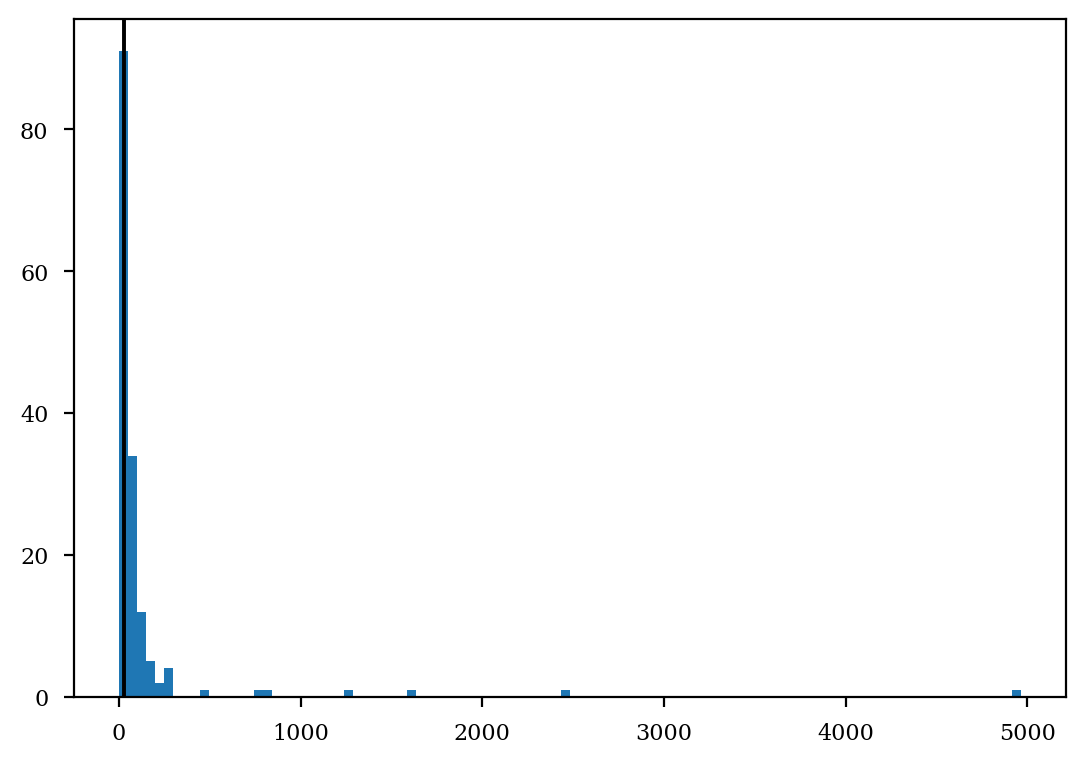

In [60]:
plt.hist(np.diff(ied_epochs.start),100)
plt.axvline(30,color="k")
plt.show()

In [88]:
# ied_epochs.start

In [5]:
from nelpy.plotting import epochplot

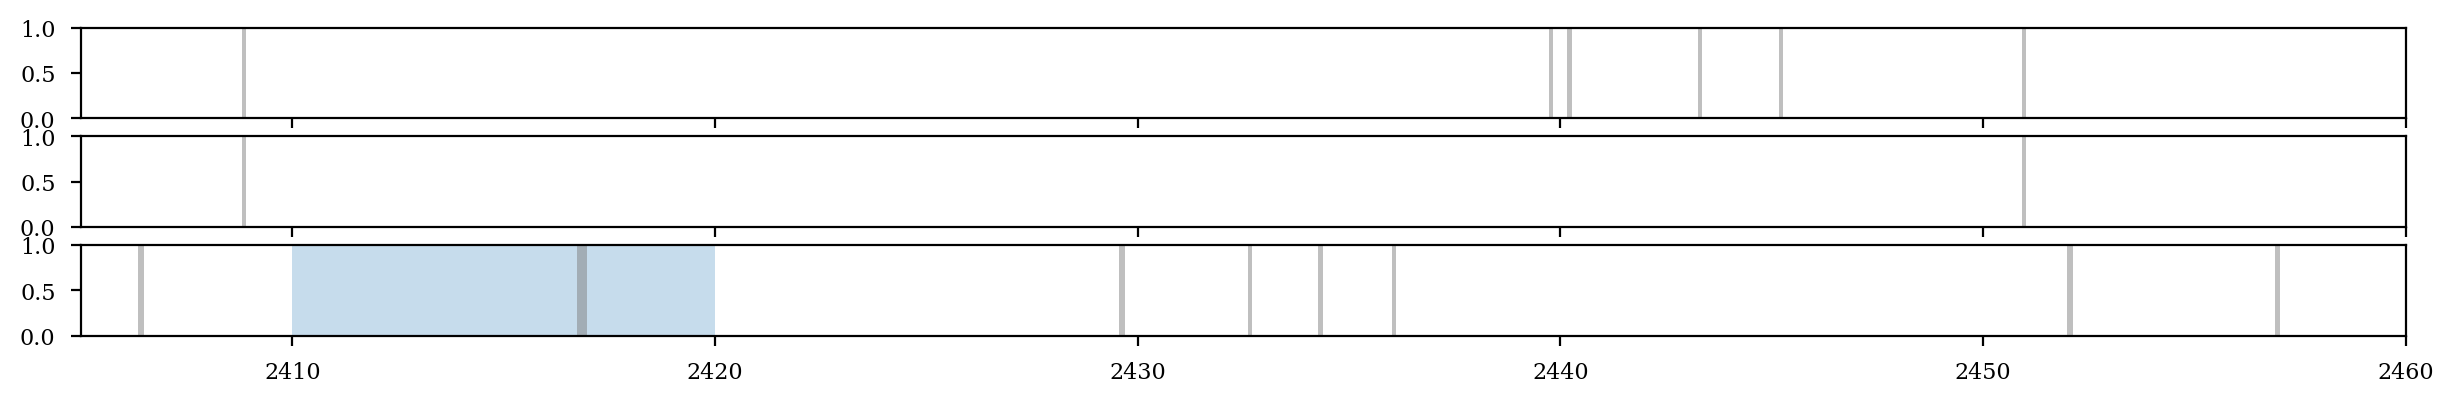

In [85]:
ied_epochs_temp = ied_epochs.loc[np.where(np.diff(ied_epochs.center)>30)]
ied = nel.EpochArray(np.array([ied_epochs_temp.start,ied_epochs_temp.stop]).T)
ied_obs = nel.EpochArray(np.array([ied_epochs.start,ied_epochs.stop]).T)

replay = nel.EpochArray(np.array([current_df.start,current_df.stop]).T)

fig,ax = plt.subplots(3,1,figsize=(15,2),sharex=True)
epochplot(ied_obs,ax=ax[0])
epochplot(ied,ax=ax[1])
epochplot(replay,ax=ax[2])
plt.xlim(2405,2460)
plt.axvspan(2410,2420,alpha=.25,zorder=-1000)

In [175]:
def classify_events(events_1, events_2, interval_pre=[-20,-10], interval_post=[0,10]):
    """
    Classifies events from events_1 as 'post', 'pre', or 'other' 
    based on their relation to events in events_2. An event is 
    classified as 'post' if it occurs 0 to 10 seconds after an event 
    in events_2, 'pre' if it occurs -20 to -10 seconds before an event 
    in events_2, and 'other' if it does not meet either of these criteria.

    Parameters:
      events_1 (list): A list of events.
      events_2 (list): A list of events.

    Returns:
      list: A list of strings with the same length as events_1. 
      Each string indicates whether the corresponding event in events_1 
      occurred 'post', 'pre', or 'other' relative to an event in events_2.
    """
    # Initialize a list to store the results
    classifications = []

    # Iterate through the events in events_1
    for event_1 in events_1:
        # Initialize a flag to track whether the event has been classified
        classified = False
        # Iterate through the events in events_2
        for event_2 in events_2:
            evt_diff = event_1 - event_2
            # Check if event_1 occurs 0 to 10 seconds after event_2
            if evt_diff > interval_post[0] and evt_diff <= interval_post[1] and not (evt_diff < interval_pre[1] and evt_diff >= interval_pre[0]):
                # If the event occurs 0 to 10 seconds after event_2, classify it as 'post' and set the flag to True
                classifications.append("post")
                classified = True
                break
            # Check if event_1 occurs -20 to -10 seconds before event_2
            elif evt_diff < interval_pre[1] and evt_diff >= interval_pre[0] and not (evt_diff > interval_post[0] and evt_diff <= interval_post[1]):
                # If the event occurs -20 to -10 seconds before event_2, classify it as 'pre' and set the flag to True
                classifications.append("pre")
                classified = True
                break
        # If the event has not been classified, classify it as 'other'
        if not classified:
            classifications.append("other")

    # Return the list of classifications
    return classifications


label = classify_events(current_df.start.values, ied_epochs.start)
current_df["label"] = label

len(label)


1799

<AxesSubplot: xlabel='label', ylabel='trajectory_score'>

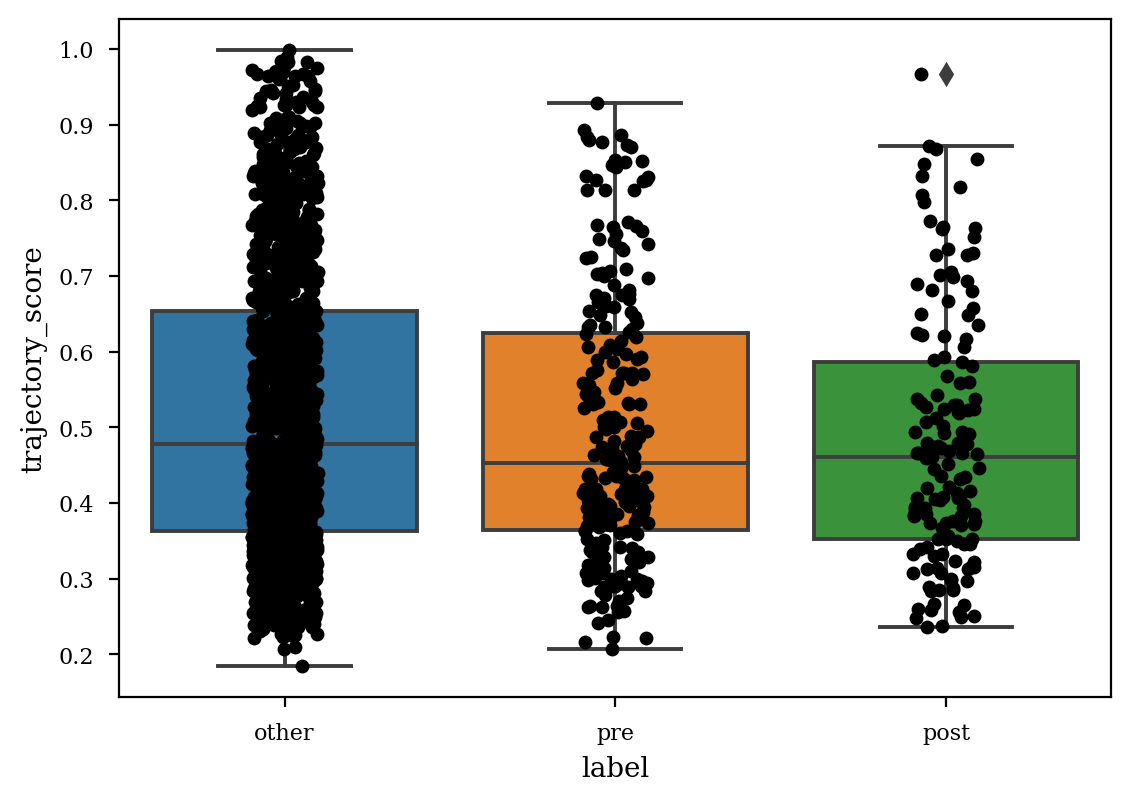

In [266]:
# current_df.query("label.str.contains('pre')")
sns.boxplot(data=current_df,x="label",y="trajectory_score")
sns.stripplot(data=current_df,x="label",y="trajectory_score",color="k")


In [141]:
# label = []
# for replay_start in current_df.start.values:
#     time_diff = replay_start - ied_epochs.start.values
#     time_diff_post = time_diff[time_diff > 0]
#     if len(time_diff_post) == 0:
#         time_diff_post = np.nan
#     if (np.min(time_diff_post) < 10) and (np.min(time_diff_post) > 0) and not ((time_diff.max() > -20) and (time_diff.max() < -10)):
#         label.append("post")
#     elif (time_diff.max() > -20) and (time_diff.max() < -10) and not ((np.min(time_diff_post) < 10) and (np.min(time_diff_post) > 0)):
#         label.append("pre")
#     else:
#         label.append("other")
# current_df["label"] = label

# current_df.query("label.str.contains('pre_ied|post_ied')")

<AxesSubplot: >

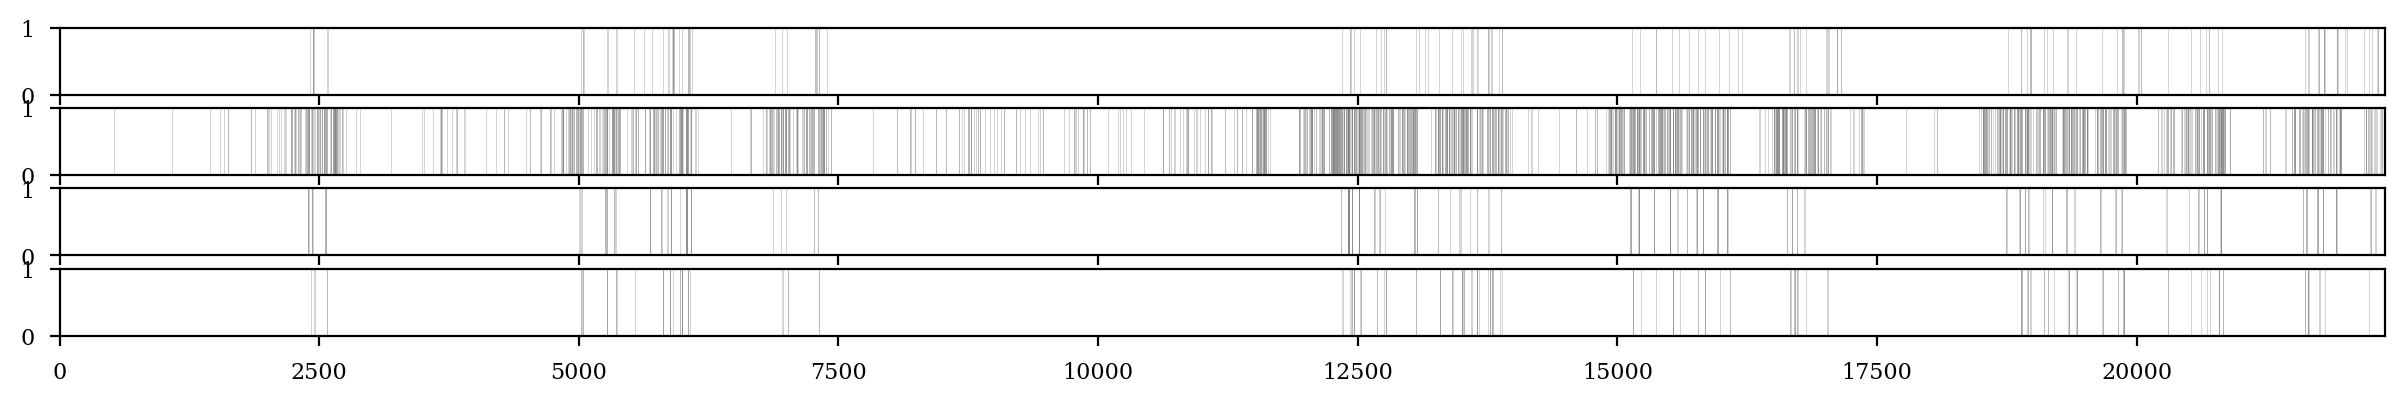

In [170]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start,ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start,current_df.stop]).T)
replay_pre = nel.EpochArray(np.array([current_df.query("label.str.contains('pre')").start,current_df.query("label.str.contains('pre')").stop]).T)
replay_post = nel.EpochArray(np.array([current_df.query("label.str.contains('post')").start,current_df.query("label.str.contains('post')").stop]).T)

fig,ax = plt.subplots(4,1,figsize=(15,2),sharex=True)
epochplot(ied_obs,ax=ax[0])
epochplot(replay,ax=ax[1])
epochplot(replay_pre,ax=ax[2])
epochplot(replay_post,ax=ax[3])


In [171]:
replay_pre,replay_post

(<EpochArray at 0x26e0a538e80: 240 epochs> of length 23.6 seconds,
 <EpochArray at 0x26e0c557670: 174 epochs> of length 17.44 seconds)

(5970.0, 6000.0)

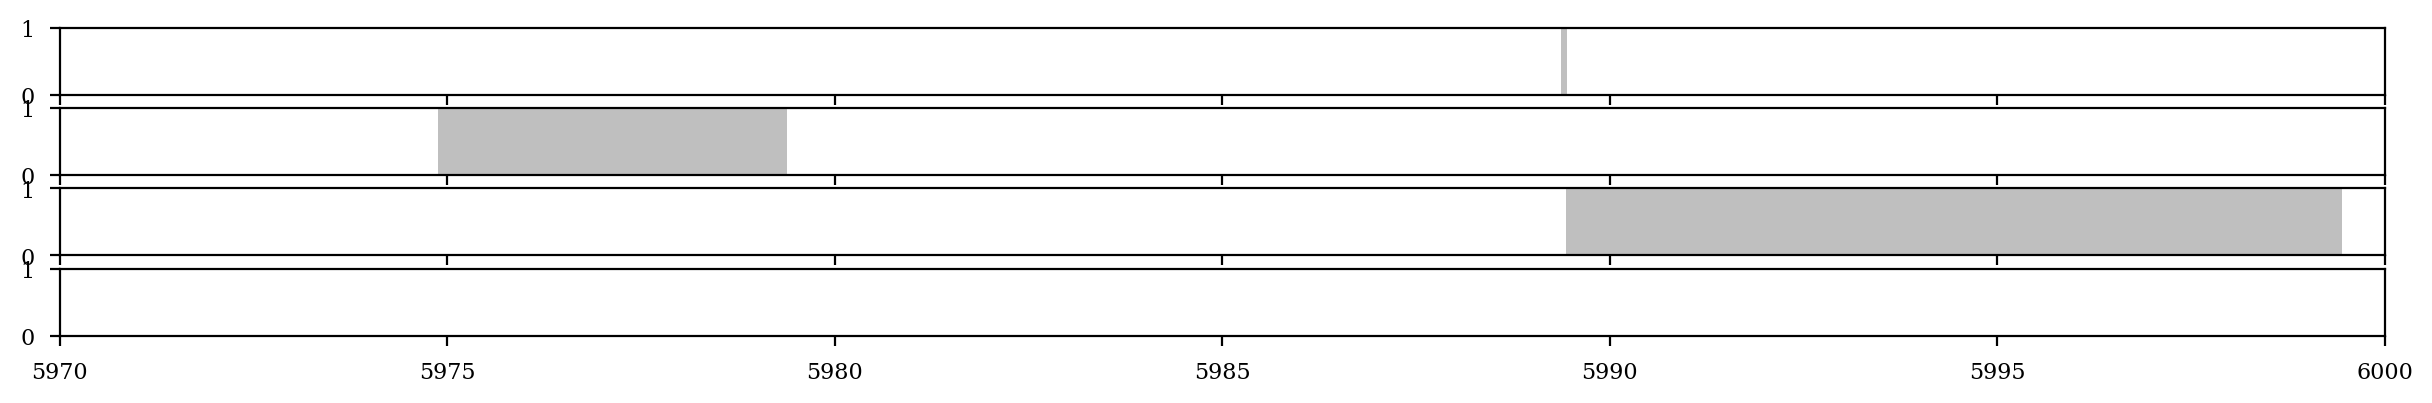

In [13]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start,ied_epochs.stop]).T)

ied_obs_pre_ = nel.EpochArray(np.array([ied_epochs.start - 20,ied_epochs.start - 10]).T)
ied_obs_post_ = nel.EpochArray(np.array([ied_epochs.stop,ied_epochs.stop+10]).T)

ied_obs_pre = ied_obs_pre_[~ied_obs_post_]

ied_obs_post = ied_obs_post_[~ied_obs_pre_]

fig,ax = plt.subplots(4,1,figsize=(15,2),sharex=True)
epochplot(ied_obs,ax=ax[0])
epochplot(ied_obs_pre,ax=ax[1])
epochplot(ied_obs_post,ax=ax[2])
plt.xlim(5970,6000)

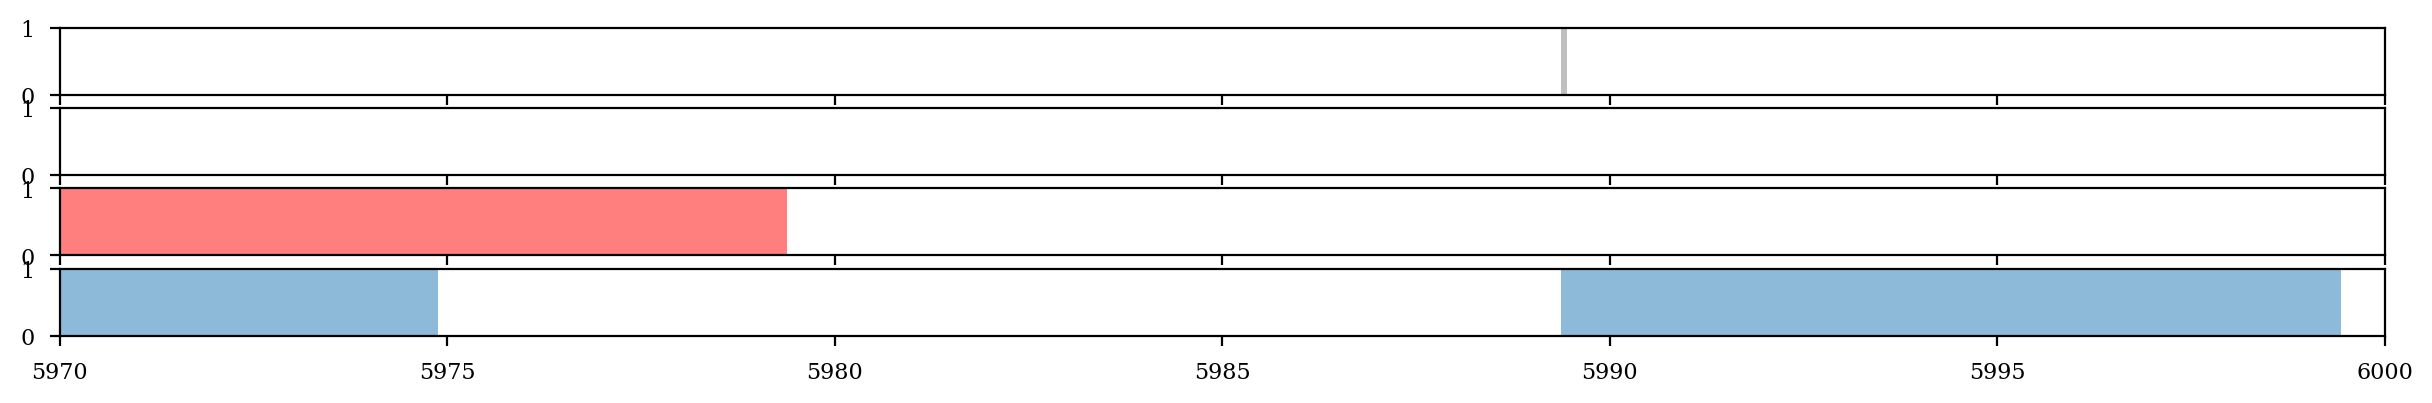

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post vs. pre: Mann-Whitney-Wilcoxon test two-sided, P_val:9.768e-01 U_stat=1.017e+04


(<AxesSubplot: xlabel='label', ylabel='trajectory_score'>,
 [<statannotations.Annotation.Annotation at 0x26a57df1f10>])

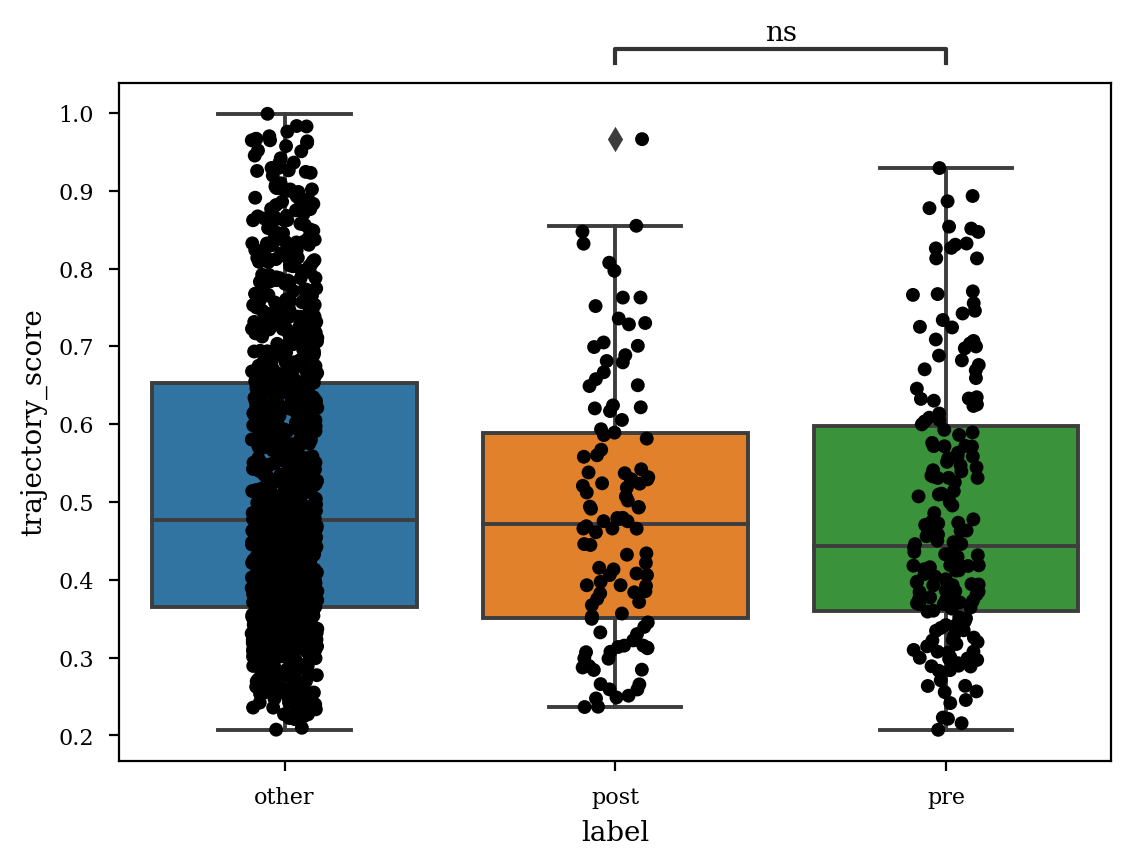

In [14]:
current_df["label"] = "other"
idx = functions.in_intervals(current_df.start.values, ied_obs_pre.data)
# idx = functions.find_intersecting_intervals(replay, replay[ied_obs_pre])
current_df.loc[idx,"label"] = "pre"
# idx = functions.find_intersecting_intervals(replay, replay[ied_obs_post])
idx = functions.in_intervals(current_df.start.values, ied_obs_post.data)
current_df.loc[idx,"label"] = "post"


ied_obs = nel.EpochArray(np.array([ied_epochs.start,ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start,current_df.stop]).T)
replay_pre = nel.EpochArray(np.array([current_df.query("label.str.contains('pre')").start,current_df.query("label.str.contains('pre')").stop]).T)
replay_post = nel.EpochArray(np.array([current_df.query("label.str.contains('post')").start,current_df.query("label.str.contains('post')").stop]).T)

fig,ax = plt.subplots(4,1,figsize=(15,2),sharex=True)
epochplot(ied_obs,ax=ax[0])
for ep in ied_obs:
    ax[2].axvspan(ep.start-20, ep.start-10,color="r",alpha=.5,zorder=-1000)
    ax[3].axvspan(ep.start, ep.stop+10,alpha=.5,zorder=-1000)
epochplot(replay,ax=ax[1])
epochplot(replay_pre,ax=ax[2])
epochplot(replay_post,ax=ax[3])
plt.xlim(5970,6000)
plt.show()


from statannotations.Annotator import Annotator
sns.boxplot(data=current_df,x="label",y="trajectory_score")
sns.stripplot(data=current_df,x="label",y="trajectory_score",color="k")

box_pairs = [
    ("pre", "post")
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=current_df,
    x="label",
    y="trajectory_score",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [269]:
pip install statannotations

  Using cached statannotations-0.5.0-py3-none-any.whl (31 kB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.1
    Uninstalling seaborn-0.12.1:
      Successfully uninstalled seaborn-0.12.1
Note: you may need to restart the kernel to use updated packages.


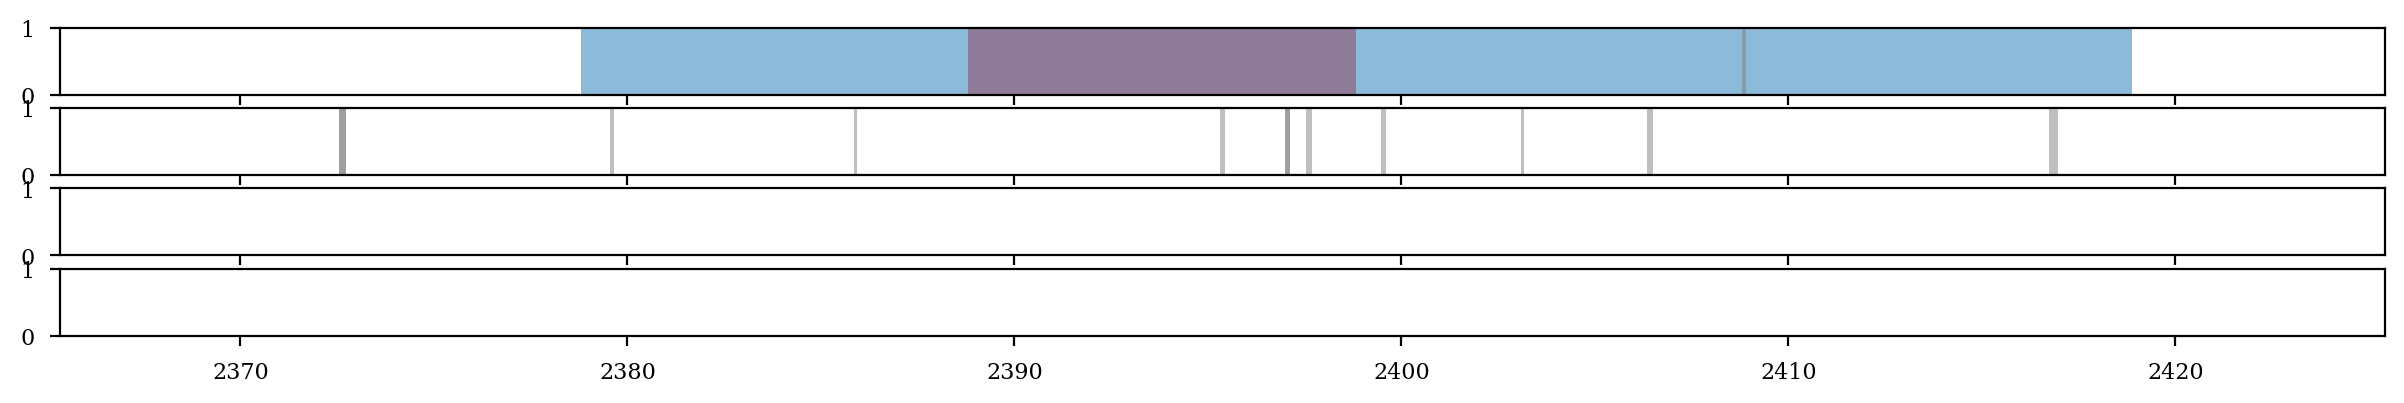

In [233]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start,ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start,current_df.stop]).T)
replay_pre = nel.EpochArray(np.array([current_df.query("label.str.contains('pre')").start,current_df.query("label.str.contains('pre')").stop]).T)
replay_post = nel.EpochArray(np.array([current_df.query("label.str.contains('post')").start,current_df.query("label.str.contains('post')").stop]).T)

fig,ax = plt.subplots(4,1,figsize=(15,2),sharex=True)
epochplot(ied_obs,ax=ax[0])
epochplot(replay,ax=ax[1])
epochplot(replay_pre,ax=ax[2])
epochplot(replay_post,ax=ax[3])

plt.xlim(2395.32485 - 30,2395.40485 + 30)
# plt.axvspan(2395.32485,2395.40485,alpha=.5,zorder=1000)
ax[0].axvspan(ied_obs[0].start-20, ied_obs[0].start-10,color="r",alpha=.5,zorder=-1000)

ax[0].axvspan(ied_obs[0].start-30, ied_obs[0].stop+10,alpha=.5,zorder=-1000)


In [107]:
np.argmin(np.abs(ied_obs.starts - 2410))

0

In [55]:
np.diff(ied_epochs.start) > 30

array([ True, False, False, False, False,  True, False,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False, False, False, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True, False,  True,  True,  True, False,  True, False, False,
        True, False,  True, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False,  True,  True, False, False, False,  True,
       False, False,  True, False,  True,  True, False,  True, False,
       False, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False, False, False,  True,
        True,  True,

In [43]:
time_range = [-20,10]
time_range = [0,10]

trajectory_score = []
events = current_df.start.values
for r in ied_epochs.start:
    idx = (events > r + time_range[0]) & (events < r + time_range[1])
    trajectory_score.append(current_df[idx].trajectory_score.values)

In [53]:
np.abs(current_df.start.values[100] - ied_epochs.start).min()

47.24235000000044

In [ ]:
for ripple_start in current_df.start.values:
    ied_epochs.start

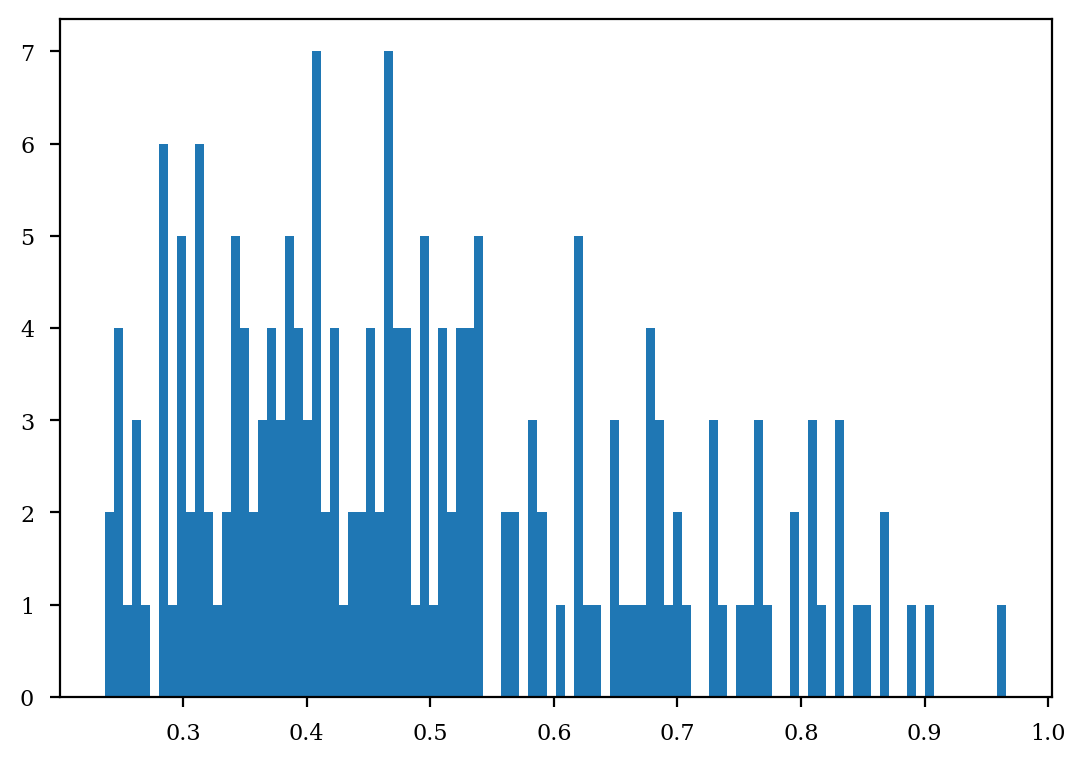

In [44]:
plt.hist(np.hstack(trajectory_score),100)
plt.show()

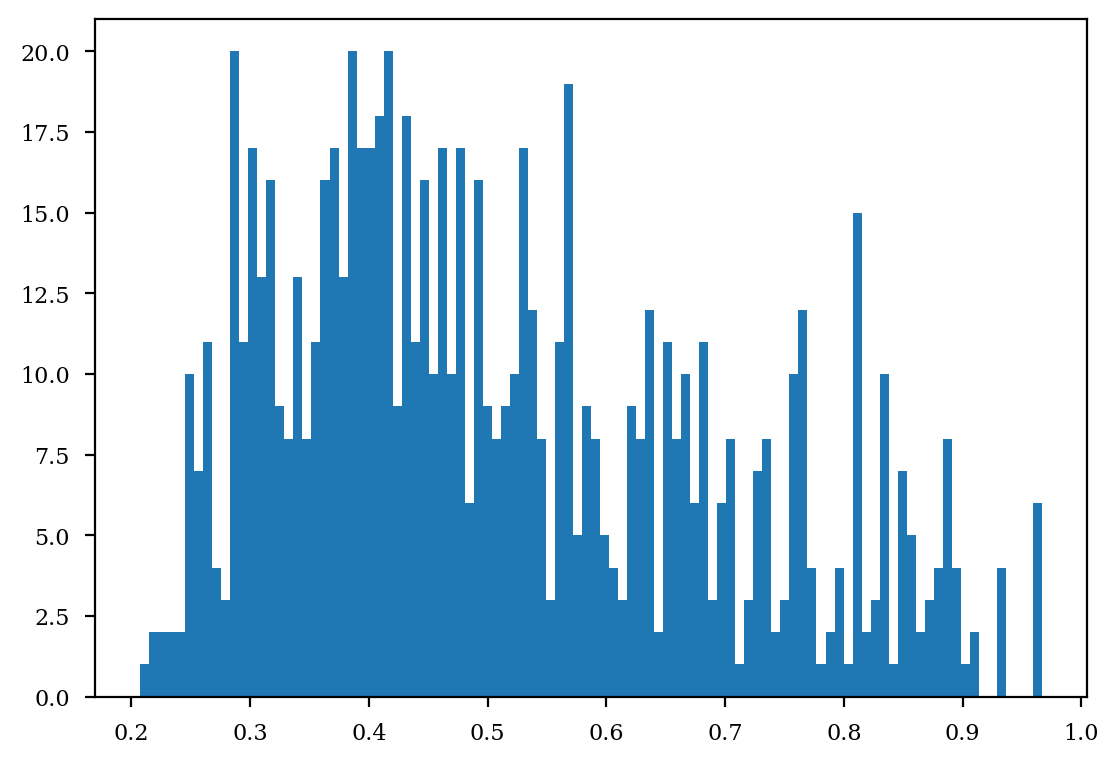

In [42]:
plt.hist(np.hstack(trajectory_score),100)
plt.show()